In [1]:
import numpy as np
import pandas as pd
from numba import njit, prange
import matplotlib.pyplot as plt

In [2]:
@njit()
def Agglomerative_Algorithm(data, thresh, runtime, min_nodes):
    N = len(data[0])
    nodes1 = np.zeros(N, dtype='float')
    nodes2 = np.zeros(N, dtype='float')
    n = np.zeros(N, dtype='int')
    for i in range (N):
        nodes1[i] = data[len(data)-2][i]
        nodes2[i] = data[len(data)-1][i]
        n[i] = 1

    node_count = N
    t = 0
    while t < runtime:
        inds = np.arange(0, node_count)
        #print(inds)
        #print(t)
        count = 0
        nodes_new1 = np.zeros(node_count, dtype='float')
        nodes_new2 = np.zeros(node_count, dtype='float')
        n_new = np.zeros(node_count, dtype='int')

        for i in range (node_count):
            if i in inds and node_count > 1:
                #print(f"i: {i}, t: {t}, ncount: {node_count}, nodes = {len(nodes1)}")
                rand = i
                while rand == i or rand == N+1:
                    rand = np.random.choice(inds)
                #print(f"rand: {rand}")

                op_dist = np.sqrt( (nodes1[rand]-nodes1[i])**2 + (nodes2[rand]-nodes2[i])**2 )
                if op_dist < thresh:
                    
                    # Calculate new opinion
                    op1 = (float(n[rand])*nodes1[rand] + float(n[i])*nodes1[i]) / float(n[rand]+n[i])
                    op2 = (float(n[rand])*nodes2[rand] + float(n[i])*nodes2[i]) / float(n[rand]+n[i])

                    nodes_new1[count] = op1
                    nodes_new2[count] = op2
                    n_new[count] = n[rand]+n[i]
                    count += 1

                    # Delete old nodes from inds
                    for j in range(len(inds)):
                        if j == i or j == rand:
                            inds[j] = N+1
                            inds[rand] = N+1

                    node_count -= 2
                            
        for i in range (len(inds)):
            if (i in inds) == True:
                nodes_new1[count] = nodes1[i]
                nodes_new2[count] = nodes2[i]
                n_new[count] = n[i]
                count += 1

        node_count = count

        nodes1 = np.zeros(count, dtype='float')
        nodes2 = np.zeros(count, dtype='float')
        n = np.zeros(count, dtype='int')

        for i in range(count):
            nodes1[i] = nodes_new1[i]
            nodes2[i] = nodes_new2[i]
            n[i] = n_new[i]

        t += 1

    final_count = 0
    for i in range (len(n)):
        if n[i] > min_nodes:
            final_count += 1

    final_op1 = np.zeros(final_count, dtype='float')
    final_op2 = np.zeros(final_count, dtype='float')
    final_n = np.zeros(final_count, dtype='int')
    final_count = 0

    for i in range(len(n)):
        if n[i] > min_nodes:
            final_op1[final_count] = nodes1[i]
            final_op2[final_count] = nodes2[i]
            final_n[final_count] = n[i]
            final_count += 1

    return final_op1, final_op2, final_n

In [7]:
def Agglomerative_Classifier(frac, num_aggs, model_type, param_dict):

    print("START")
    if num_aggs % 2 == 0:
        print("ERROR! Uneven number of agglomerative runs is needed.\n")
        return 0

    alphas = param_dict['alphas']
    cosds = param_dict['cosds']
    sims = param_dict['sims']
    beta = param_dict['beta']
    model_params = param_dict['model_params']

    saves = np.zeros((len(alphas), len(cosds)))

    for i in range(len(alphas)):
        for j in range(len(cosds)):
            print(f"alpha: {alphas[i]:.1f}, cosd: {cosds[j]:.2f}")
            
            # Count wether algorithm says dataset is consensus, polarization or ideology
            # First entry is cons-counter, 2nd polarization and 3rd ideology
            counts = np.zeros(3, dtype=int)
            for k in range(sims):
                
                # Load data
                if model_type == 'Gaussian':
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Gaussian_Activity/Gaussian_a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_m{model_params[0]}_std{model_params[1]}_{k+1}.csv", header=None)
                    data = df.to_numpy()
                elif model_type == 'Activity':
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Activity_Penalty/Activity_a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_m{model_params[0]}_{k+1}.csv", header=None)
                    data = df.to_numpy()
                elif model_type == 'Original':
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Original\\a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_{k+1}.csv", header = None)
                    data = df.to_numpy()
                elif model_type == 'PenMat':
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\PenMat\PenMat_a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_mod0_param0.1_{k+1}.csv", header = None)
                    data = df.to_numpy()
                elif model_type == 'ProbPenMat':
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\ProbPenMat\ProbPenMat_a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_param0.1_{k+1}.csv", header = None)
                    data = df.to_numpy()
                elif model_type == 'Moderators':
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Moderators\Influencers_a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_m50_N25_str0.3_{k+1}.csv", header = None)
                    data = df.to_numpy()
                elif model_type == 'Moderators2':
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Test\Influencers_a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_m250_N5_str0.3_{k+1}.csv", header = None)
                    data = df.to_numpy()
                elif model_type == 'ModeratorsAct':
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Moderators\Influencers_a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_m50_N25_str0.3_act_{k+1}.csv", header = None)
                    data = df.to_numpy()

                # Number of nodes
                N = len(data[0])
                # Neglect nodes that stay around zero.
                sorts = np.argsort( data[0] )
                # Transpose to access nodes
                sorted = data.T[sorts]
                Num = int(N * (1-frac))
                # Transpose back
                data = sorted[:Num].T

                # Create counting array
                for l in range (num_aggs):
                    #print(f"i: {i};\tj: {j};\tk: {k}\tl: {l}")
                    # Perform algorithm and classify via angles of nodes
                    ops1, ops2, ns = Agglomerative_Algorithm(data, 1.0, 500, 150)
                    last_nodes = []
                    for m in range (len(ns)):
                        last_nodes.append( [ops1[m], ops2[m], ns[m]] )
                    last_nodes = np.array(last_nodes)
                    # Each entry of angle_count represents number of nodes in a quadrant.
                    angle_count = np.zeros(4, dtype = int)
                    # Sort the nodes into nodes that have |op_i|<1 and those that don´t
                    cons_nodes = []
                    pol_nodes = []
                    tol = 30*2*np.pi/360
                    for node in last_nodes:
                        angle = np.arctan2(node[0], node[1])
                        if angle >= np.pi/4 - tol and angle <= np.pi/4 + tol:
                            angle_count[0] += 1
                        if angle >= 3*np.pi/4 - tol and angle <= 3*np.pi/4 + tol:
                            angle_count[1] += 1
                        if angle >= -3*np.pi/4 - tol and angle <= -3*np.pi/4 + tol:
                            angle_count[2] += 1
                        if angle >= -np.pi/4 - tol and angle <= -np.pi/4 + tol:
                            angle_count[3] += 1
                        # Check wether each of the nodes absolute opinions are smaller than one
                        if abs(node[0]) <= 0.5 and abs(node[1]) <= 0.5:
                            cons_nodes.append(node)
                        else:
                            pol_nodes.append(node)

                    # Now classify which of the three states is present
                    # If the nodes in |op1| < 1 and |op2| < 1 have more nodes than the others,
                    # consensus happens
                    if len(cons_nodes) != 0:
                        node_sum1 = 0
                        node_sum2 = 0
                        for node in cons_nodes:
                            node_sum1 += node[2]
                        for node in pol_nodes:
                            node_sum2 += node[2]
                        if node_sum1 >= node_sum2:
                            counts[0] += 1    
                            continue
                    # Check the other cases
                    elif angle_count[0] != 0 and angle_count[2] != 0 and angle_count[1] == 0 and angle_count[3] == 0:
                        counts[2] += 1
                        continue
                    elif angle_count[1] != 0 and angle_count[3] != 0 and angle_count[0] == 0 and angle_count[2] == 0:
                        counts[2] += 1
                        continue
                    elif angle_count[1] != 0 and angle_count[3] != 0 and angle_count[0] != 0 and angle_count[2] != 0:
                        counts[1] += 1 
                        continue

                
            saves[i][j] = np.argmax(counts)
            print(saves[i][j])

    pd.DataFrame(saves).to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Original\Heatmap_agg_moderators_active.csv", index = False, header = False)
    return saves

[391 345 300 583 208]
[ 1.02404085 -1.13415639 -1.08303872 -0.02342624  1.10615635]
[-1.01198976  1.13353849 -1.07607647  0.03139979  1.1102409 ]


(-10.0, 10.0)

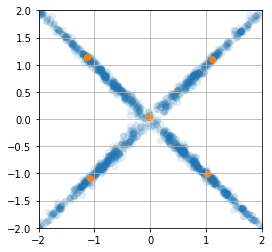

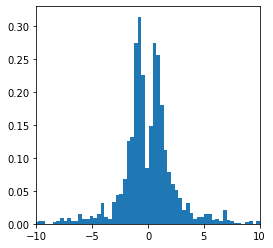

In [67]:
df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Original\\a2.0_b5.0_cosd-0.05_1.csv", header = None)
data = df.to_numpy()

ops1, ops2, ns = Agglomerative_Algorithm(data, 1.0, 200, 150)

plt.figure(figsize=(4,4))
plt.scatter(data[3], data[4], alpha=0.1)
plt.scatter(ops1,ops2)
plt.grid()
plt.xlim(-2,2)
plt.ylim(-2,2)

print(ns)
print(ops1)
print(ops2)

plt.figure(figsize=(4,4))
plt.hist(data[4], density=True, bins = 200)
plt.xlim(-10,10)

In [8]:
params_activity_penalty = {
    'alphas': np.arange(0.0,4.1,0.1),
    'beta': 5.0,
    'cosds': np.arange(-0.25,1.05,0.05),
    'model_params': np.array([0.2]),
    'sims': 3,
    'frac': 0.0
}

res = Agglomerative_Classifier(0.0, 5, 'ModeratorsAct', params_activity_penalty)

START
alpha: 0.0, cosd: -0.25
0.0
alpha: 0.0, cosd: -0.20
0.0
alpha: 0.0, cosd: -0.15
0.0
alpha: 0.0, cosd: -0.10
0.0
alpha: 0.0, cosd: -0.05
0.0
alpha: 0.0, cosd: -0.00
0.0
alpha: 0.0, cosd: 0.05
0.0
alpha: 0.0, cosd: 0.10
0.0
alpha: 0.0, cosd: 0.15
0.0
alpha: 0.0, cosd: 0.20
0.0
alpha: 0.0, cosd: 0.25
0.0
alpha: 0.0, cosd: 0.30
0.0
alpha: 0.0, cosd: 0.35
0.0
alpha: 0.0, cosd: 0.40
0.0
alpha: 0.0, cosd: 0.45
0.0
alpha: 0.0, cosd: 0.50
0.0
alpha: 0.0, cosd: 0.55
0.0
alpha: 0.0, cosd: 0.60
0.0
alpha: 0.0, cosd: 0.65
0.0
alpha: 0.0, cosd: 0.70
0.0
alpha: 0.0, cosd: 0.75
0.0
alpha: 0.0, cosd: 0.80
0.0
alpha: 0.0, cosd: 0.85
0.0
alpha: 0.0, cosd: 0.90
0.0
alpha: 0.0, cosd: 0.95
0.0
alpha: 0.0, cosd: 1.00
0.0
alpha: 0.1, cosd: -0.25
0.0
alpha: 0.1, cosd: -0.20
0.0
alpha: 0.1, cosd: -0.15
0.0
alpha: 0.1, cosd: -0.10
0.0
alpha: 0.1, cosd: -0.05
0.0
alpha: 0.1, cosd: -0.00
0.0
alpha: 0.1, cosd: 0.05
0.0
alpha: 0.1, cosd: 0.10
0.0
alpha: 0.1, cosd: 0.15
0.0
alpha: 0.1, cosd: 0.20
0.0
alpha: 0.1

In [51]:
print(res)
pd.DataFrame(res).to_csv(f"D:/Daten mit Änderungen/Physik/Bachelorarbeit/Generated_Data/Heatmap_orig.csv", index = False, header = False)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]]
